In [1]:
import os
import glob
import cv2
import numpy as np
import random
from adjustText import adjust_text
import plotly.express as px
from tifffile import TiffFile
import os
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)

base_dir = r"N:\00_Exchange\Alois\data\data_processed"
os.chdir(r"N:\\00_Exchange\\Alois")



In [53]:


def compute_area_fraction(data_folder):
    # Initialize a list to store results
    results = []
    
    treatments = ['FG12', 'PBS', '11C7', 'NG004']
    
    for treatment in treatments:
        vessel_path = os.path.join(data_folder, 'data_processed', treatment)
        mask_path = os.path.join(data_folder, 'retina_masks', treatment)
       
        
        for subject in os.listdir(vessel_path):
            print(f'Processing subject: {subject}')

            subject_folder = os.path.join(vessel_path, subject)
            vessel_file = os.path.join(subject_folder, f'{subject}_reconstructed_multi.tif')
            mask_file = os.path.join(mask_path, f'{subject}_mask.tif')

            
            if os.path.exists(vessel_file) and os.path.exists(mask_file):

                layers_vessel = []
                with TiffFile(vessel_file) as tif:
                    for page in tif.pages:
                        layer = page.asarray()
                        layers_vessel.append(layer)
                vessel_img = np.stack(layers_vessel)



                mask_img = tiff.imread(mask_file)

                num_layers = min(vessel_img.shape[0], mask_img.shape[0])
                
                for layer in range(num_layers):
                    vessel_layer = vessel_img[layer]
                    mask_layer = mask_img[layer]
                    
                    retina_area = (mask_layer > 0).sum()
                    if retina_area > 0:
                        vessel_area = (vessel_layer > 0).sum()
                        area_fraction = vessel_area / retina_area
                    else:
                        area_fraction = 0
                    
                    eye = 'OD' if 'OD' in subject else 'OE'
                    results.append({
                        'Treatment': treatment,
                        'SubjectID': subject,
                        'Eye': 'Right' if eye == 'OD' else 'Left',
                        'LayerNumber': layer,
                        'AreaFraction': area_fraction,
                        'VesselArea': retina_area
                    })
    
    results_df = pd.DataFrame(results)
    return results_df




In [54]:

# Path to your data_full folder
data_folder = 'data_full'
df = compute_area_fraction(data_folder)


Processing subject: Akita28_OD_25x
Processing subject: Akita28_OE_25x
Processing subject: Akita30_OD_25x
Processing subject: Akita30_OE_25x
Processing subject: Akita32_OD_25x
Processing subject: Akita32_OE_25x
Processing subject: Akita33_OD_25x
Processing subject: Akita33_OE_25x
Processing subject: Akita34_OD_25x
Processing subject: Akita34_OE_25x
Processing subject: Akita35_OD_25x
Processing subject: Akita35_OE_25x
Processing subject: Akita36_OD_25x
Processing subject: Akita36_OE_25x
Processing subject: Akita37_OD_25x
Processing subject: Akita37_OE_25x
Processing subject: Akita13_OD_25x
Processing subject: Akita13_OE_25x
Processing subject: Akita17_OD_25x
Processing subject: Akita17_OE_25x
Processing subject: Akita18_OD_25x
Processing subject: Akita18_OE_25x
Processing subject: Akita46_OD_25x
Processing subject: Akita46_OE_25x
Processing subject: Akita47_OD_25x
Processing subject: Akita47_OE_25x
Processing subject: Akita48_OD_25x
Processing subject: Akita48_OE_25x
Processing subject: 

In [55]:
df['SubjectID'] = df['SubjectID'].str.extract(r'Akita(\d+)')
df['Eye'] = df['Eye'].replace({'Left': 'OE', 'Right': 'OD'})



In [56]:
# Export the DataFrame 'df' to a CSV file
df.to_csv('total_area.csv', index=False)


In [2]:
df = pd.read_csv('area_fraction_layers.csv')


In [3]:
import pandas as pd

# Assuming the initial DataFrame 'df' setup is correct

def align_layers(group):
    max_area_layer = group['AreaFraction'].idxmax()
    shift = group.loc[max_area_layer, 'LayerNumber']
    group['AlignedLayerNumber'] = group['LayerNumber'] - shift
    return group

df_aligned = df.groupby(['SubjectID', 'Eye'], as_index=False).apply(align_layers)

df_aligned.reset_index(drop=True, inplace=True)
df_aligned.sort_values(by=['SubjectID', 'Eye', 'AlignedLayerNumber'], inplace=True)



In [3]:
df_aligned.to_csv('area_fraction_aligned_layers.csv', index=False)


NameError: name 'df_aligned' is not defined

In [5]:
df_export = df_aligned[['SubjectID', 'Eye', 'Treatment', 'LayerNumber', 'AlignedLayerNumber']]

df_export.to_csv('alignment_layers.csv', index=False)

In [4]:
df = df_aligned
df = df.drop(columns=['LayerNumber'])
df = df.rename(columns={'AlignedLayerNumber': 'LayerNumber'})

df.to_csv(r'E:\Retina-Segmentation\Analysis\Analysis Full\area_fraction.csv', index=False)


In [8]:
df = pd.read_csv(r'E:\Retina-Segmentation\Analysis\Analysis Full\area_fraction.csv')

## Plots

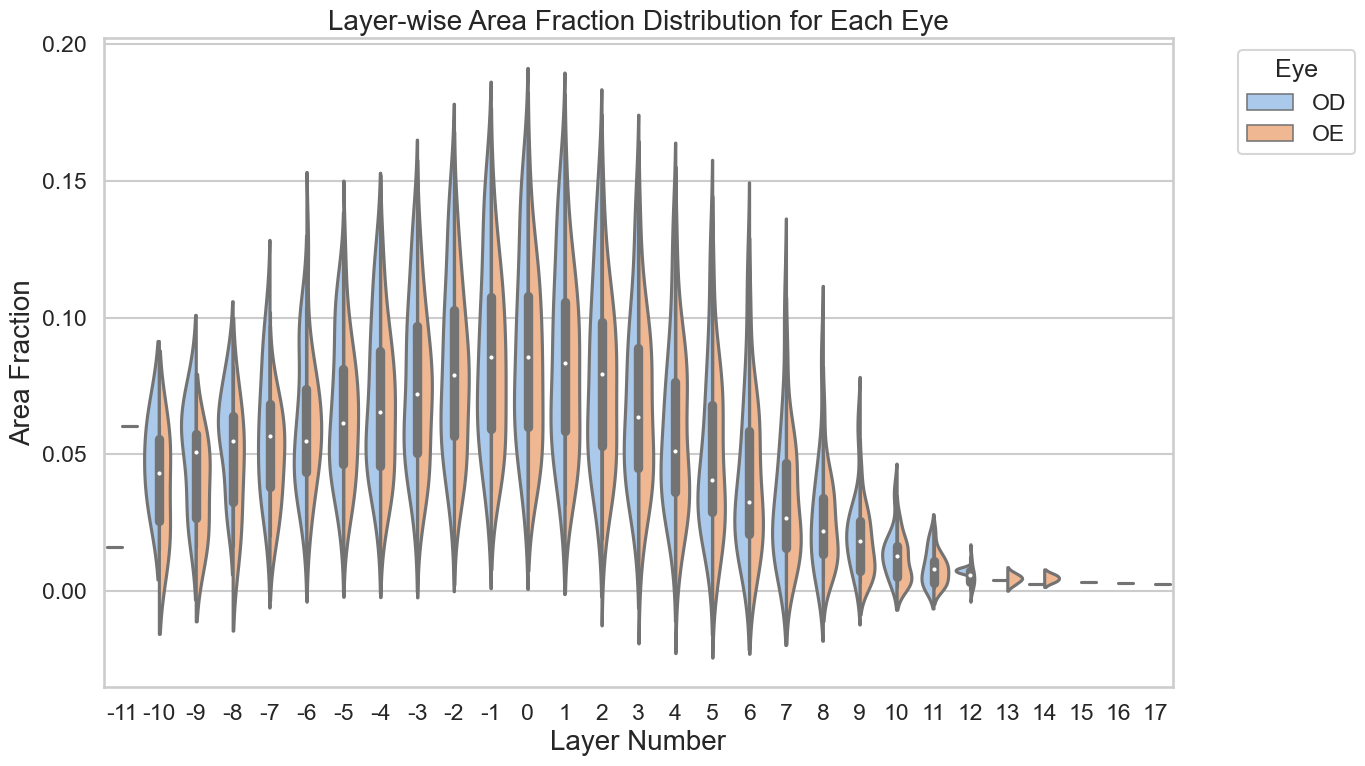

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame with the additional 'LayerNumber' and 'AreaFraction' columns

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", context="talk")

# Create a violin plot showing the distribution of Area Fraction for each layer, separated by Eye
violin_plot = sns.violinplot(x="LayerNumber", y="AreaFraction", hue="Eye", data=df, palette="pastel", split=True)

plt.title('Layer-wise Area Fraction Distribution for Each Eye', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Area Fraction', fontsize=20)
plt.legend(title='Eye', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\alois\AppData\Local\Temp\ipykernel_4060\3896302814.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="LayerNumber", y="AreaFraction", hue="Treatment", style="Eye", markers=True, dashes=False, data=df, ax=ax, palette=palette, ci=None)
C:\Users\alois\AppData\Local\Temp\ipykernel_4060\3896302814.py:13: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(x="LayerNumber", y="AreaFraction", hue="Treatment", style="Eye", markers=True, dashes=False, data=df, ax=ax, palette=palette, ci=None)
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is depr

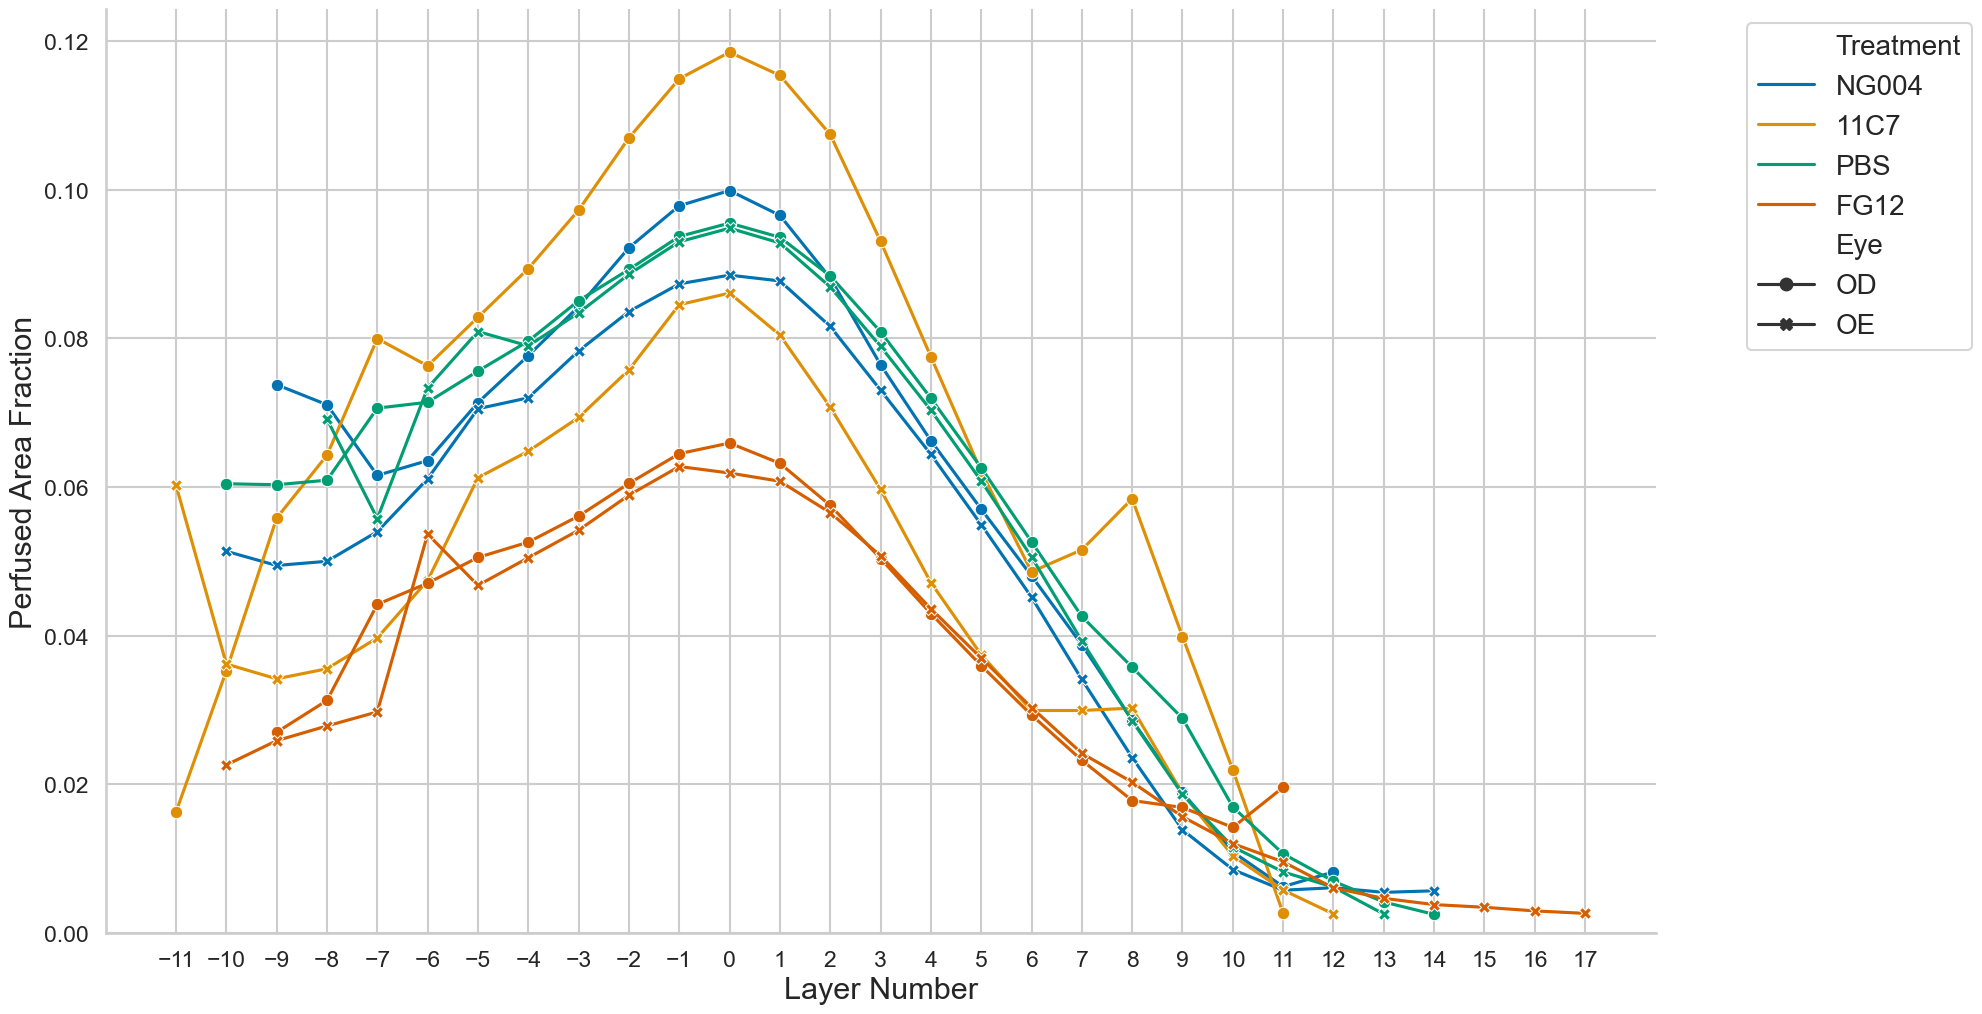

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style to a professional one suitable for publications
sns.set_style("whitegrid")

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(20, 12))  # Slightly larger for better detail in print

# Create the line plot with clearer differentiation for print
palette = sns.color_palette("colorblind")  # Optimal for colorblindness and grayscale printing
sns.lineplot(x="LayerNumber", y="AreaFraction", hue="Treatment", style="Eye", markers=True, dashes=False, data=df, ax=ax, palette=palette, ci=None)

# Enhance the title and labels for clarity and readability in print
ax.set_xlabel('Layer Number', fontsize=22)
ax.set_ylabel('Perfused Area Fraction', fontsize=22)
ax.set_ylim(0)

# Fine-tune the x-ticks for better scale representation
ax.set_xticks(np.arange(min(df['LayerNumber']), max(df['LayerNumber'])+1, 1.0))

# Place the legend outside the plot, ensuring it doesn’t overlap with data
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)

# Remove the top and right spines for a cleaner look
sns.despine()

# Save the figure in a high-resolution format suitable for high-quality publication
fig.savefig("area_fraction_trend.png", dpi=300, bbox_inches='tight', format='png')


C:\Users\alois\AppData\Local\Temp\ipykernel_4060\2486505356.py:26: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(x="LayerNumber", y="AreaFraction", hue="Eye", style="Eye", markers=True,
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\alois\AppData\Local\Temp\ipykernel_4060\2486505356.py:26: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(x="LayerNumber", y="AreaFraction", hue="E

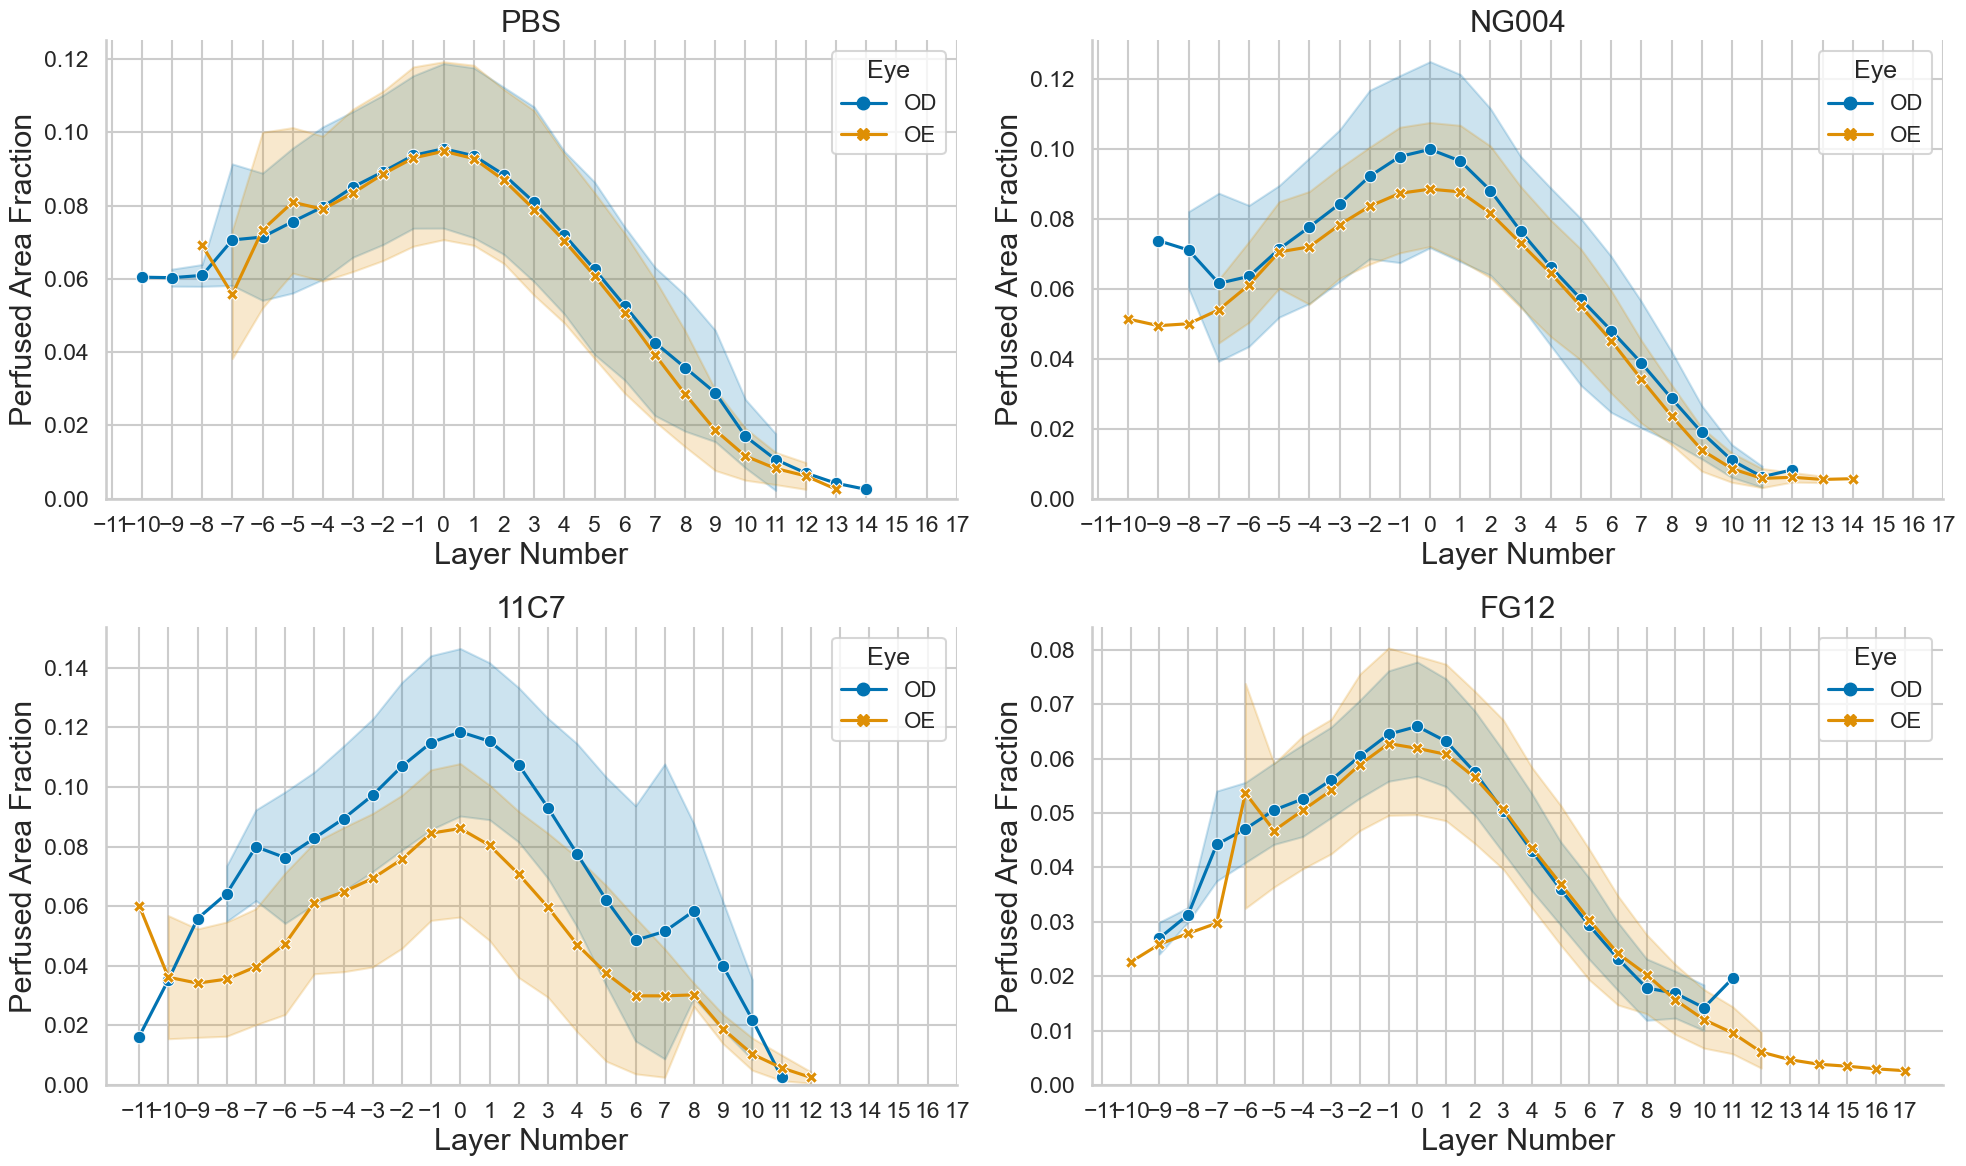

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Set style for publication quality
sns.set_style("whitegrid")

# Define treatments
treatments = ['PBS', 'NG004', '11C7', 'FG12']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))  # Adjust size as necessary
axes = axes.flatten()  # Flatten the array for easier iteration

# Define the color palette
palette = sns.color_palette("colorblind")

# Plot each treatment in a separate subplot
for ax, treatment in zip(axes, treatments):
    # Filter the DataFrame for the current treatment
    subset = df[df['Treatment'] == treatment]
    
    # Create line plot for the subset
    sns.lineplot(x="LayerNumber", y="AreaFraction", hue="Eye", style="Eye", markers=True,
                 dashes=False, data=subset, ax=ax, palette=palette)
    
    # Set titles, labels, and ticks
    ax.set_ylim(0)
    ax.set_title(f'{treatment}', fontsize=22)
    ax.set_xlabel('Layer Number', fontsize=22)
    ax.set_ylabel('Perfused Area Fraction', fontsize=22)
    ax.set_xticks(np.arange(min(df['LayerNumber']), max(df['LayerNumber'])+1, 1))
    ax.legend(title='Eye', loc='upper right', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Remove the top and right spines for a cleaner look in all subplots
sns.despine()

# Save the figure in high-resolution
fig.savefig("area_fraction_by_treatment.png", dpi=300, bbox_inches='tight', format='png')


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


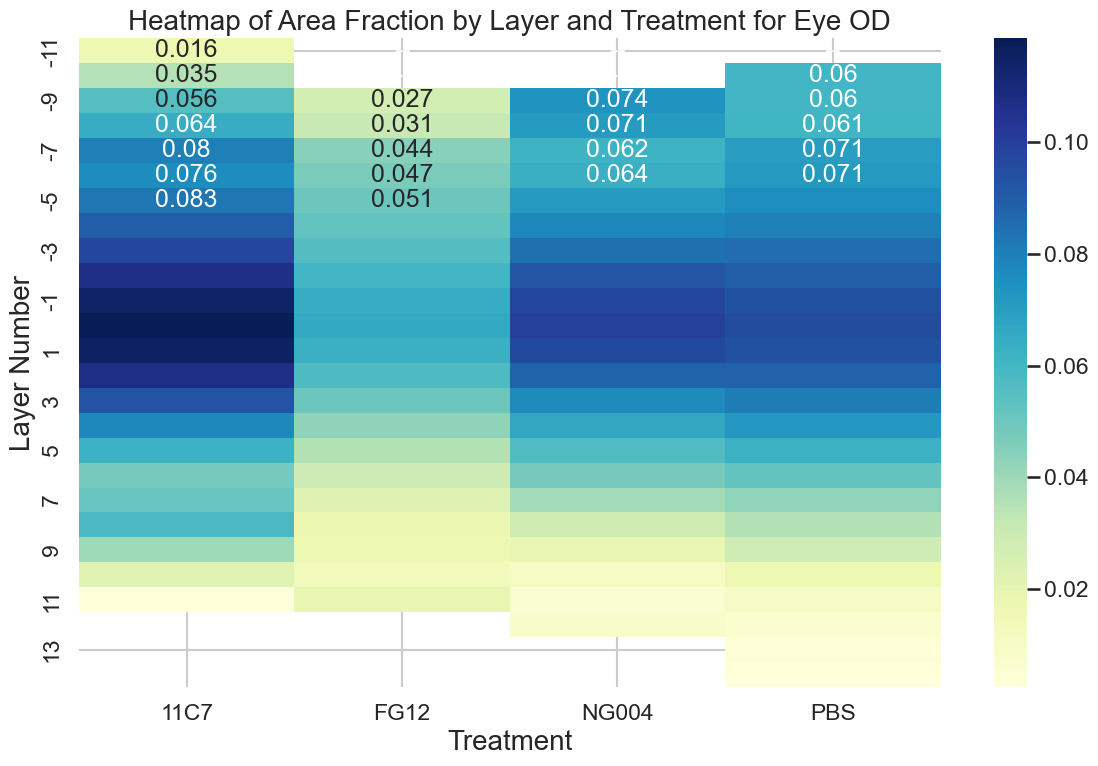

In [24]:
# Pivot the dataframe to create a matrix of LayerNumber vs. Treatment with AreaFraction as values
heatmap_data = df[df['Eye'] == 'OD'].pivot_table(index='LayerNumber', columns='Treatment', values='AreaFraction', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title('Heatmap of Area Fraction by Layer and Treatment for Eye OD', fontsize=20)
plt.xlabel('Treatment', fontsize=20)
plt.ylabel('Layer Number', fontsize=20)
plt.tight_layout()
plt.show()


## Plots by treatment

c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


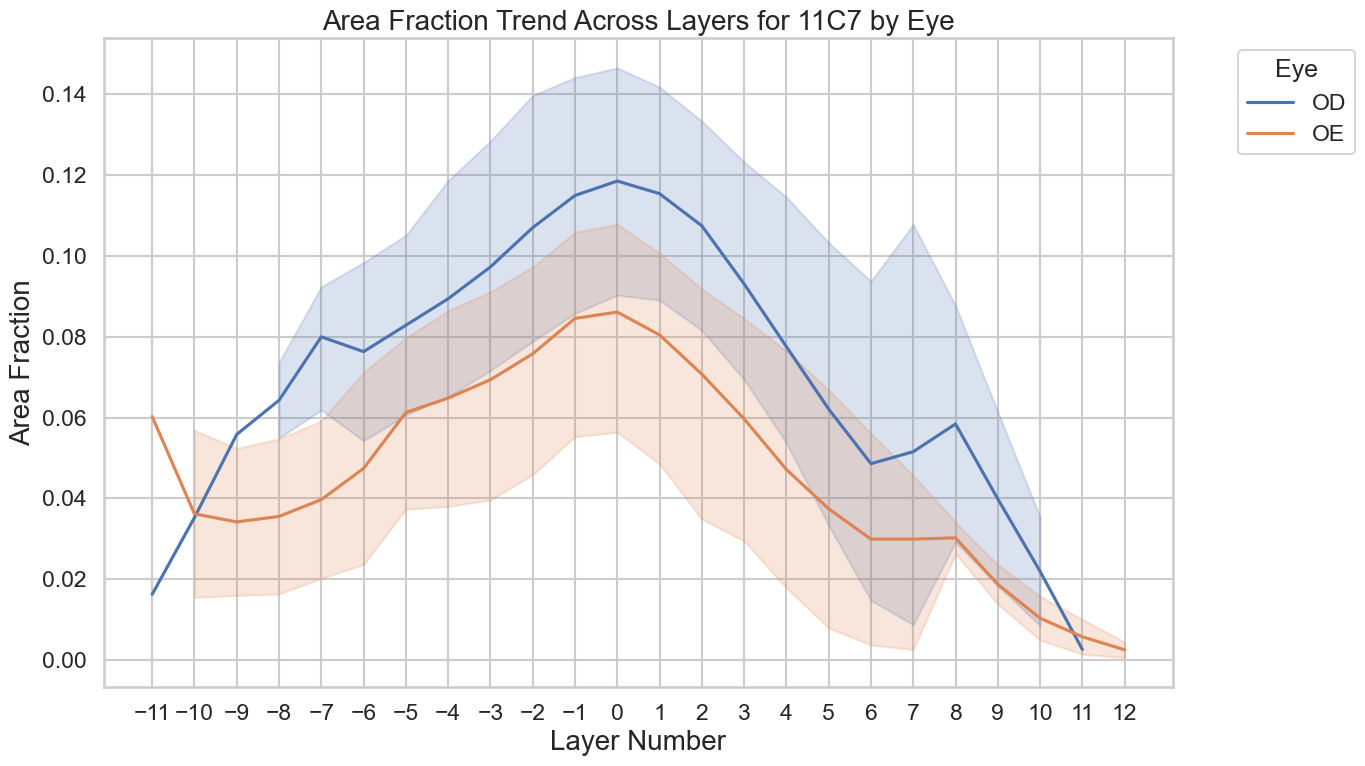

In [25]:
import numpy as np
treatment = '11C7'
df_filtered = df[df['Treatment'] == treatment]

plt.figure(figsize=(14, 8))
# Now, the 'hue' parameter is set to "Eye" since we're only dealing with one treatment
sns.lineplot(x="LayerNumber", y="AreaFraction", hue="Eye", markers=True, dashes=False, data=df_filtered)
plt.title(f'Area Fraction Trend Across Layers for {treatment} by Eye', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Area Fraction', fontsize=20)
# Adjusting the legend title since we're now separating lines by "Eye" instead of "Treatment and Eye"
plt.legend(title='Eye', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ensure x-axis values are integers
plt.xticks(np.arange(min(df_filtered['LayerNumber']), max(df_filtered['LayerNumber'])+1, 1.0))

plt.tight_layout()
plt.show()


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


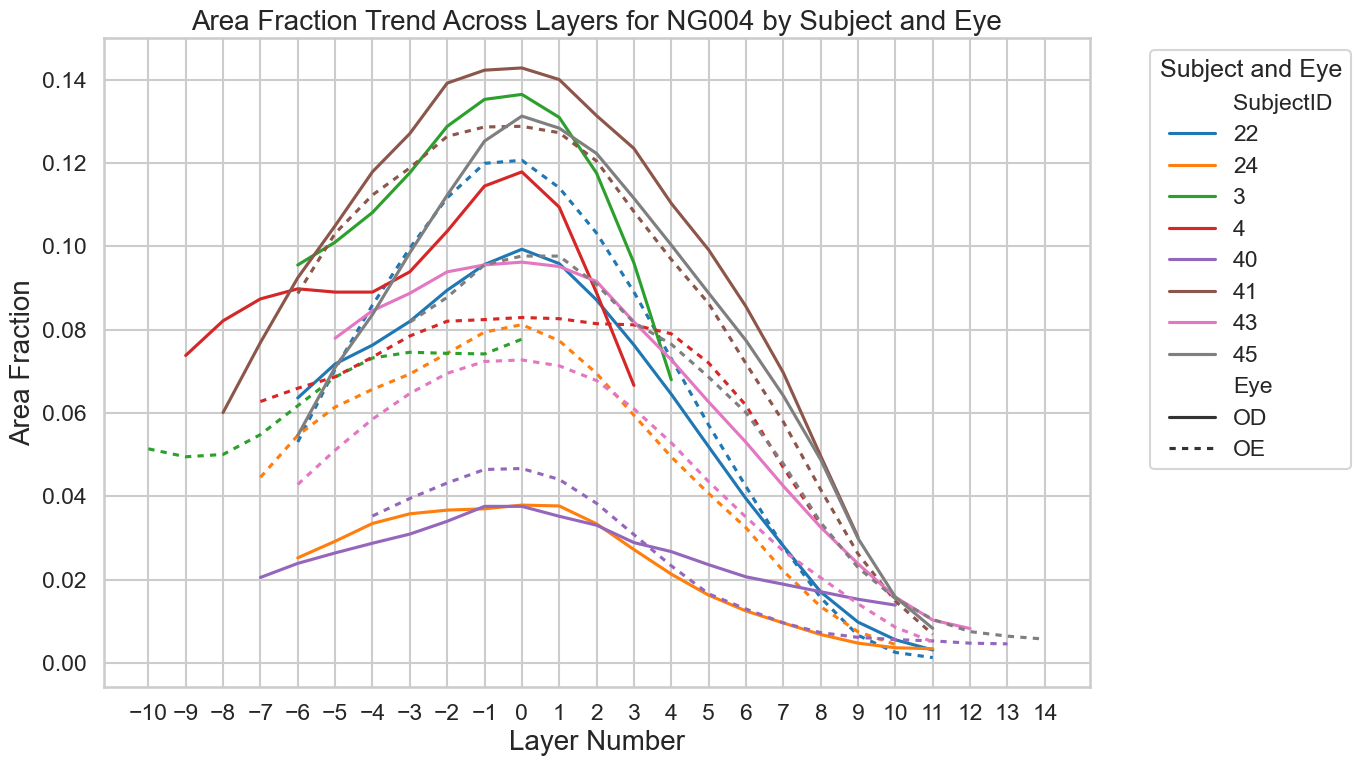

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


treatment = 'NG004'
df_filtered = df[df['Treatment'] == treatment]

plt.figure(figsize=(14, 8))

style_order = ["OD", "OE"]
dashes = {'OD': '', 'OE': (2, 2)}  


sns.lineplot(x="LayerNumber", y="AreaFraction", hue="SubjectID", style="Eye",
             dashes=dashes, data=df_filtered, palette="tab10", style_order=style_order)

plt.title(f'Area Fraction Trend Across Layers for {treatment} by Subject and Eye', fontsize=20)
plt.xticks(np.arange(min(df_filtered['LayerNumber']), max(df_filtered['LayerNumber'])+1, 1.0))

plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Area Fraction', fontsize=20)

plt.legend(title='Subject and Eye', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Delta OD-OE

In [27]:
df_filtered = df.dropna(subset=['AreaFraction'])
df_pivot = df_filtered.pivot_table(index=['SubjectID', 'Treatment', 'LayerNumber'], columns='Eye', values='AreaFraction').reset_index()
df_pivot['AreaFractionDiff'] = df_pivot['OD'] - df_pivot['OE']
df_diff = df_pivot.melt(id_vars=['SubjectID', 'Treatment', 'LayerNumber'], value_vars=['AreaFractionDiff'], 
                        var_name='Metric', value_name='AreaFraction').dropna()

df_diff = df_diff[['SubjectID', 'Treatment', 'LayerNumber', 'AreaFraction']]
df_diff['DeltaAreaFraction'] = df_diff['AreaFraction']


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


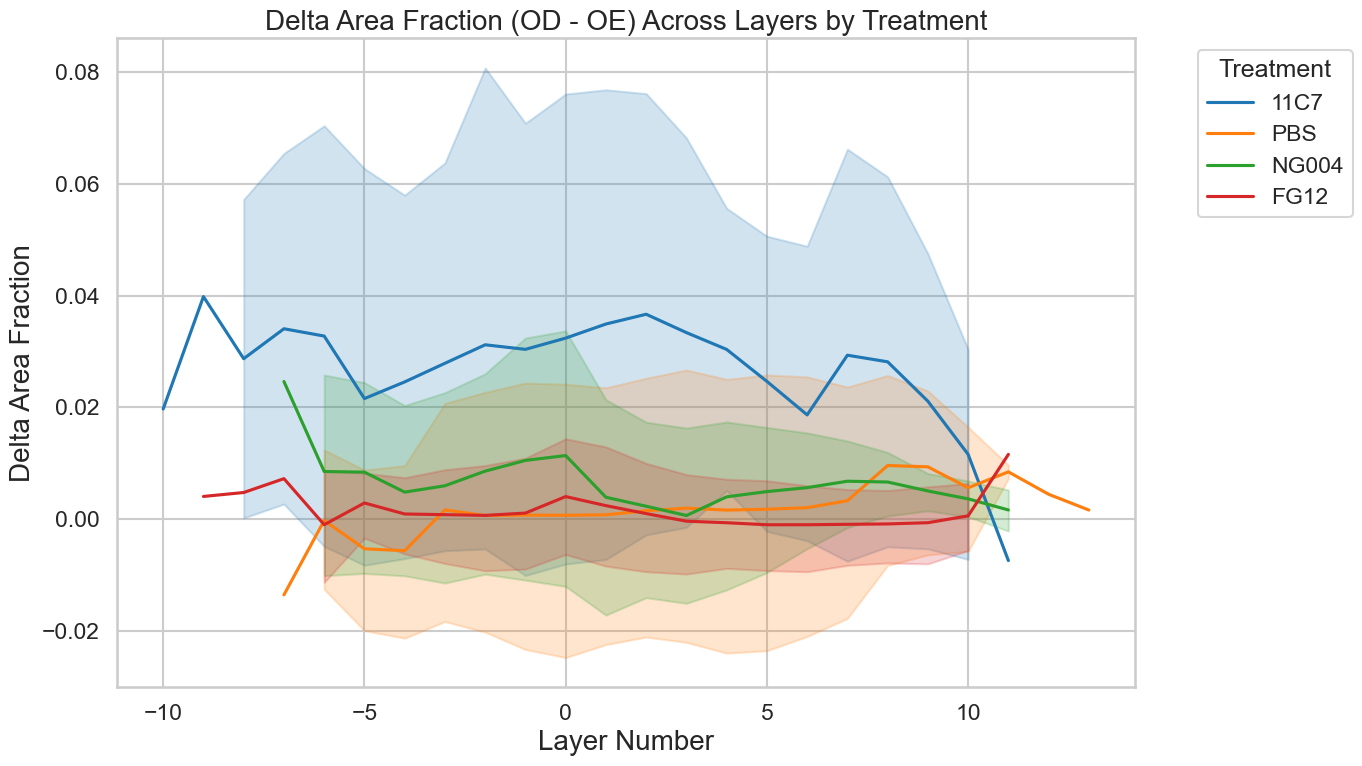

In [28]:
plt.figure(figsize=(14, 8))

# Plotting the delta of Area Fraction between OD and OE for each treatment
sns.lineplot(x="LayerNumber", y="DeltaAreaFraction", hue="Treatment", data=df_diff, markers=True, dashes=False, palette='tab10')

plt.title('Delta Area Fraction (OD - OE) Across Layers by Treatment', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Delta Area Fraction', fontsize=20)
plt.legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [14]:
treatment = 'FG12'
df_filtered = df_diff[df_diff['Treatment'] == treatment]

plt.figure(figsize=(14, 8))

sns.lineplot(x="LayerNumber", y="DeltaAreaFraction", hue="SubjectID", markers=True, dashes=False,
             data=df_filtered, palette="tab10")

# Calculate the mean of DeltaAreaFraction for each LayerNumber
average_trend = df_filtered.groupby("LayerNumber")["DeltaAreaFraction"].mean()

# Plot the average trend line
plt.plot(average_trend.index, average_trend.values, color='red', linewidth=5, alpha=0.9, label='Average Trend')

plt.title(f'Delta Area Fraction Trend Across Layers for {treatment} by Subject', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Delta Area Fraction', fontsize=20)

plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()



NameError: name 'df_diff' is not defined

# AreaFrac comparison group for layers

Median 'Area Fraction' values by 'Treatment' and 'Eye':
  Treatment Eye  AreaFraction
0      11C7  OD      0.105995
1      11C7  OE      0.088085
2      FG12  OD      0.058647
3      FG12  OE      0.055090
4     NG004  OD      0.097722
5     NG004  OE      0.081695
6       PBS  OD      0.092813
7       PBS  OE      0.091201


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\

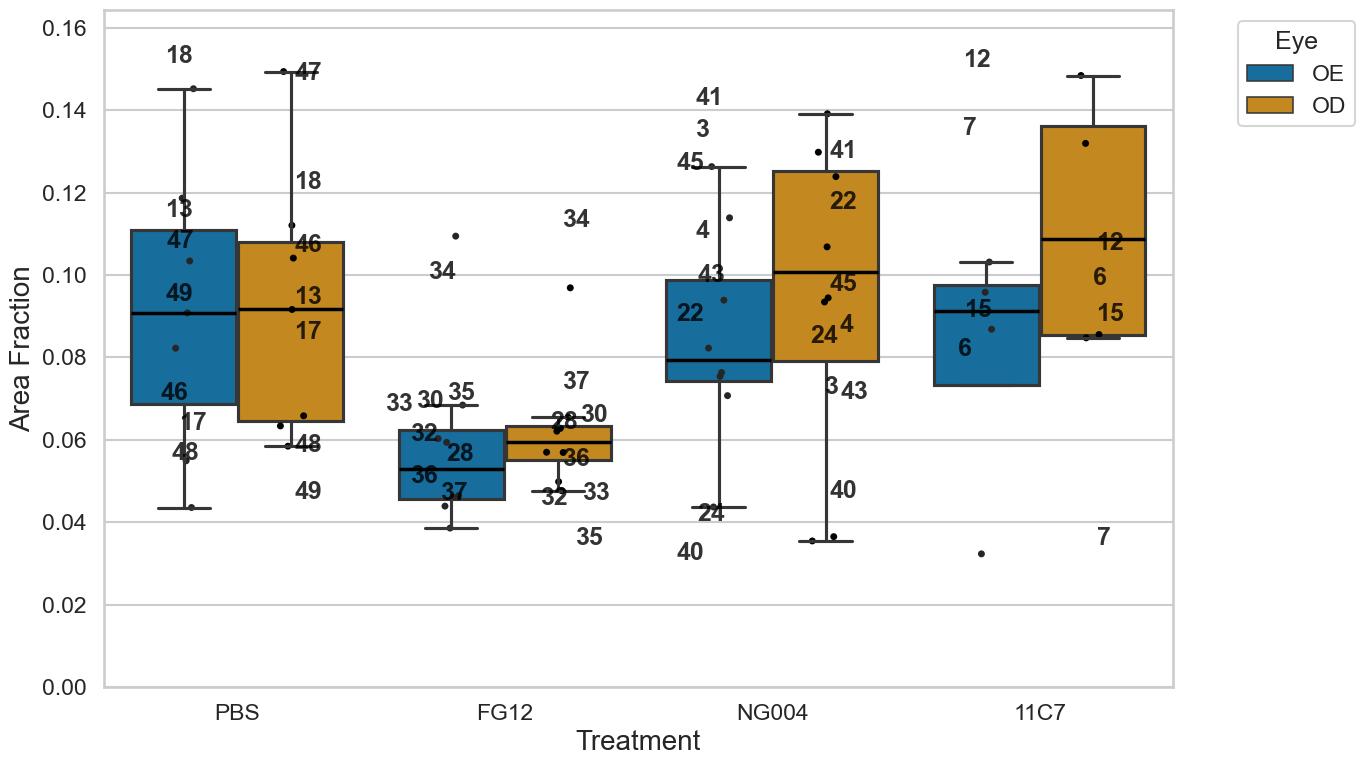

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import pandas as pd

# Assuming 'df' is already loaded and contains the necessary columns.

# Define the layers of interest.
layers_of_interest = [-2, -1, 0, 1, 2]

# Filter the DataFrame to only include these layers.
df_layers = df[df['LayerNumber'].isin(layers_of_interest)]

# Compute the mean Area Fraction for the filtered data.
df_mean_area = df_layers.groupby(['SubjectID', 'Eye', 'Treatment']).agg({'AreaFraction':'mean'}).reset_index()

df_median_area = df_layers.groupby(['Treatment', 'Eye'])['AreaFraction'].median().reset_index()

# Print the median values.
print("Median 'Area Fraction' values by 'Treatment' and 'Eye':")
print(df_median_area)

# Define the specific order for treatments
treatment_order = ['PBS', 'FG12', 'NG004', '11C7']

# Sort df_mean_area according to the specified order
df_mean_area['Treatment'] = pd.Categorical(df_mean_area['Treatment'], categories=treatment_order, ordered=True)
df_mean_area.sort_values('Treatment', inplace=True)

# Create a figure with a specified size for clarity.
plt.figure(figsize=(14, 8))

# Set the style of the plot to ensure a clean background.
sns.set(style="whitegrid", context="talk")

# Customize the boxplot to highlight the median.
medianprops = dict(linestyle='-', linewidth=2.5, color='Black')

# Create a boxplot with customized median line.
box_plot = sns.boxplot(x="Treatment", y="AreaFraction", hue="Eye", data=df_mean_area, palette="colorblind", showfliers=False, medianprops=medianprops, order=treatment_order)

# Overlay a stripplot on the boxplot.
strip_plot = sns.stripplot(x="Treatment", y="AreaFraction", hue="Eye", data=df_mean_area, dodge=True, jitter=0.1, marker='o', color='black', size=5, zorder=1, order=treatment_order)

# Handle the legend: place it outside the plot to prevent occlusion of data.
handles, labels = strip_plot.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Eye', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the y-axis limit to accommodate the median annotations.
max_y = df_mean_area['AreaFraction'].max()
plt.ylim(0, max_y + max_y * 0.1)

# Label the axes and set the title.
plt.xlabel('Treatment', fontsize=20)
plt.ylabel('Area Fraction', fontsize=20)

# Add subject IDs to the plot.
dodge_value = 0.25
texts = []
for i, row in df_mean_area.iterrows():
    dodge_direction = dodge_value if row['Eye'] == 'OE' else -dodge_value
    x_position = treatment_order.index(row['Treatment']) + dodge_direction
    texts.append(plt.text(x=x_position, y=row['AreaFraction'], s=row['SubjectID'], color='black', alpha=0.80, fontweight='bold', ha='center'))

# Ensure the texts do not overlap with each other using adjustText.
adjust_text(texts)

# Final adjustments before showing the plot.
plt.tight_layout()

# Show the plot.
plt.show()


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


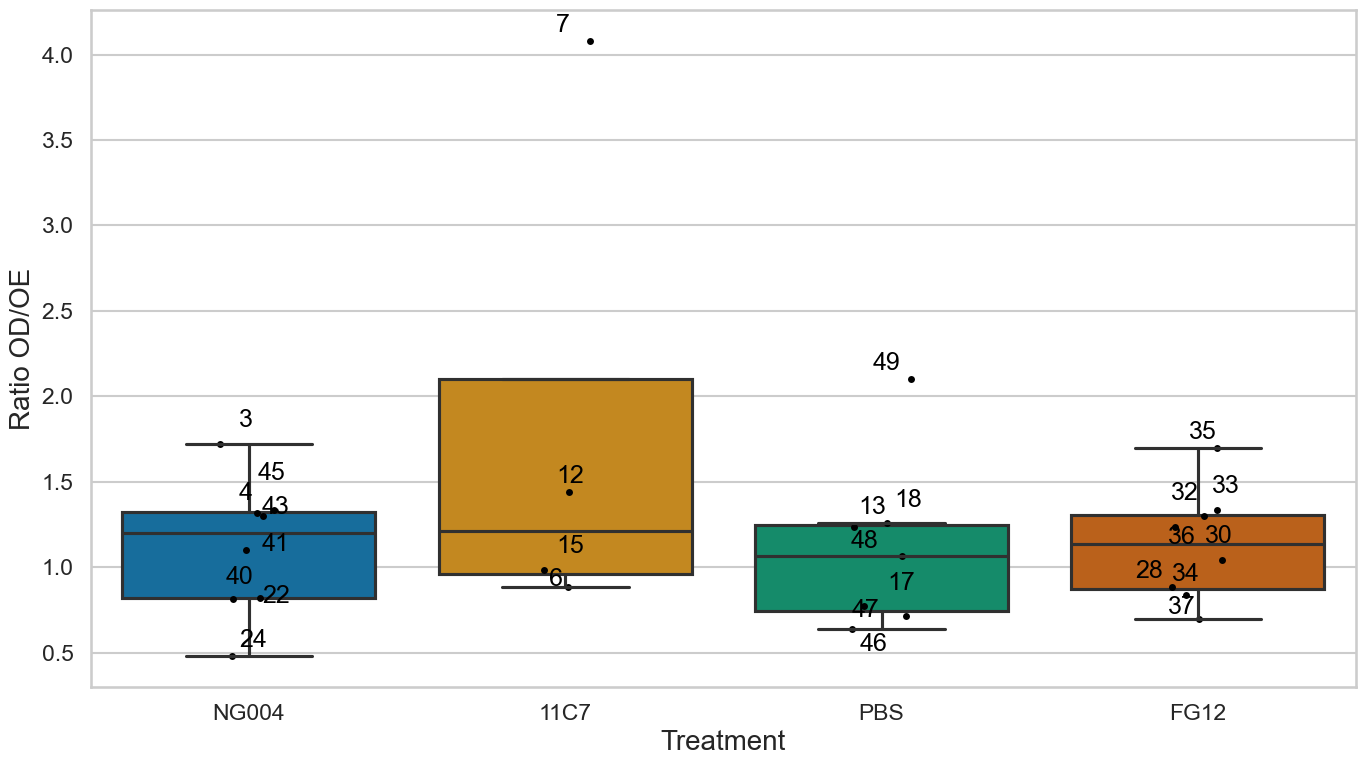

In [31]:
layers_of_interest = [-2, -1, 0, 1, 2]
df_layers = df[df['LayerNumber'].isin(layers_of_interest)]
df_mean_area = df_layers.groupby(['SubjectID', 'Eye', 'Treatment']).agg({'AreaFraction':'mean'}).reset_index()

# Step 2: Pivot the DataFrame to get OD and OE columns
df_pivot = df_mean_area.pivot_table(index=['SubjectID', 'Treatment'], columns='Eye', values='AreaFraction').reset_index()

# Rename columns for clarity
df_pivot.columns = ['SubjectID', 'Treatment', 'AreaFraction_OD', 'AreaFraction_OE']

# Step 3: Calculate the ratio OD/OE
df_pivot['Ratio_OD_OE'] = df_pivot['AreaFraction_OD'] / df_pivot['AreaFraction_OE']

# Cleaning up infinite values and NaNs resulting from division by zero or missing data
df_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 4: Plotting
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", context="talk")

# Boxplot for overall distribution
box_plot = sns.boxplot(x="Treatment", y="Ratio_OD_OE", data=df_pivot, palette="colorblind", showfliers=False)

# Stripplot for individual subject data points
strip_plot = sns.stripplot(x="Treatment", y="Ratio_OD_OE", data=df_pivot, jitter=0.1, marker='o', color='black', size=5, zorder=1)

plt.xlabel('Treatment', fontsize=20)
plt.ylabel('Ratio OD/OE', fontsize=20)

# Adding text annotations for each point
texts = []
for index, row in df_pivot.iterrows():
    x_position = list(df_pivot['Treatment'].unique()).index(row['Treatment'])  # Adjust x position based on treatment
    texts.append(plt.text(x=x_position, y=row['Ratio_OD_OE'], s=row['SubjectID'], color='black', ha='center', va='bottom'))

# Automatically adjust text to minimize overlap
adjust_text(texts)

plt.tight_layout()
plt.show()


Median 'Ratio OD/OE' values by 'Treatment':
  Treatment  Ratio_OD_OE
0      11C7     1.212809
1      FG12     1.137845
2     NG004     1.199597
3       PBS     1.063957


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


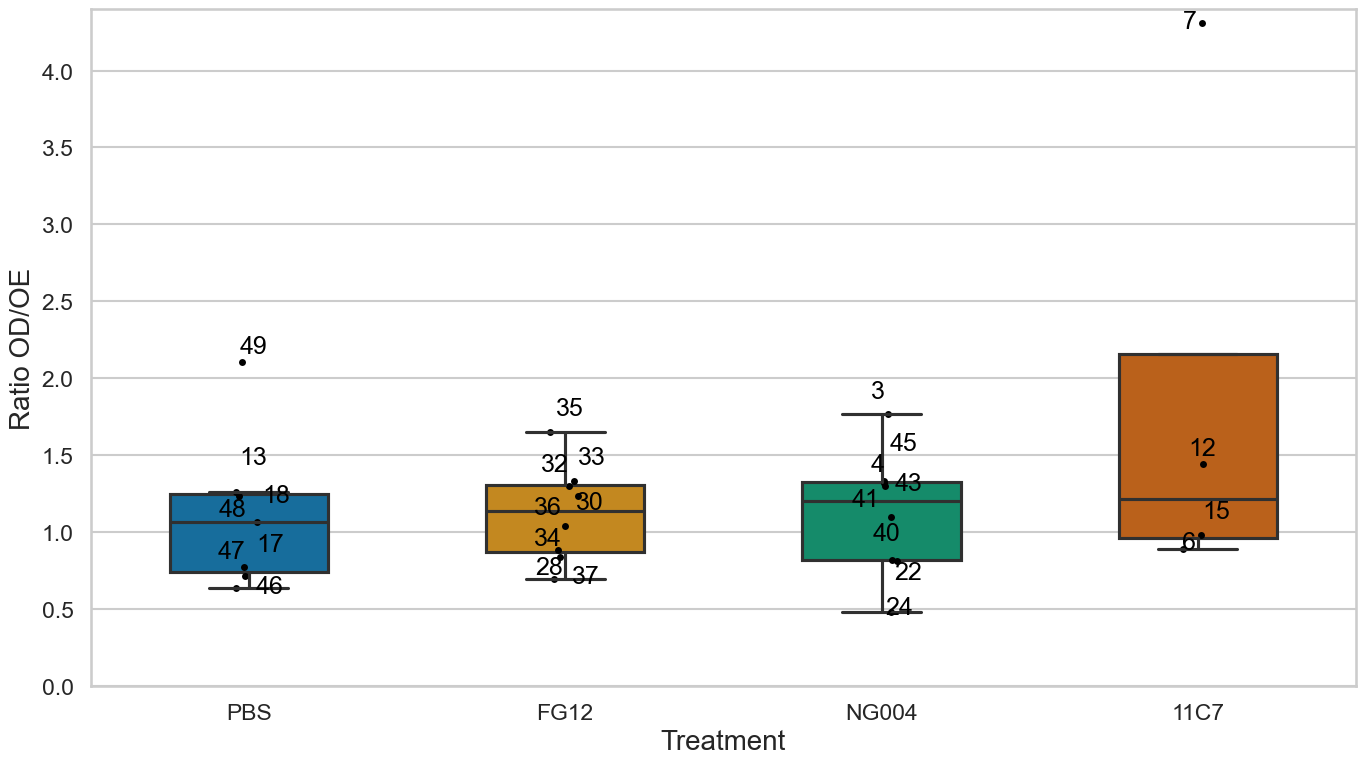

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import numpy as np

# Assuming 'df' is your DataFrame and already imported.

# Step 1: Filter for layers of interest
layers_of_interest = [-2, -1, 0, 1, 2]
df_layers = df[df['LayerNumber'].isin(layers_of_interest)]

# Step 2: Calculate OD/OE ratio per layer for each SubjectID, Eye, and Treatment
# First, create a pivot table to separate OD and OE for each layer
df_layer_pivot = df_layers.pivot_table(index=['SubjectID', 'Treatment', 'LayerNumber'], columns='Eye', values='AreaFraction').reset_index()
df_layer_pivot.columns = ['SubjectID', 'Treatment', 'LayerNumber', 'AreaFraction_OD', 'AreaFraction_OE']

# Calculate the ratio OD/OE for each entry
df_layer_pivot['Ratio_OD_OE'] = df_layer_pivot['AreaFraction_OD'] / df_layer_pivot['AreaFraction_OE']
df_layer_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)  # Cleaning up any infinite or NaN values from zero division

# Step 3: Average these ratios by subject and treatment
df_mean_ratios = df_layer_pivot.groupby(['SubjectID', 'Treatment']).agg({'Ratio_OD_OE':'mean'}).reset_index()

# Step 3b: Calculate median values for ratios and print
df_median_values = df_mean_ratios.groupby('Treatment')['Ratio_OD_OE'].median().reset_index()
print("Median 'Ratio OD/OE' values by 'Treatment':")
print(df_median_values)

# Define the specific order for treatments
treatment_order = ['PBS', 'FG12', 'NG004', '11C7']

# Sort df_mean_ratios according to the specified order
df_mean_ratios['Treatment'] = pd.Categorical(df_mean_ratios['Treatment'], categories=treatment_order, ordered=True)
df_mean_ratios.sort_values('Treatment', inplace=True)

# Step 4: Plotting
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", context="talk")

# Ensure boxplot and stripplot follow the specified treatment order
box_plot = sns.boxplot(x="Treatment", y="Ratio_OD_OE", data=df_mean_ratios, palette="colorblind", showfliers=False, width=0.5, order=treatment_order)
strip_plot = sns.stripplot(x="Treatment", y="Ratio_OD_OE", data=df_mean_ratios, jitter=0.05, marker='o', color='black', size=5, zorder=1, order=treatment_order)

max_y = 4
plt.ylim(0, max_y + max_y * 0.1)

plt.xlabel('Treatment', fontsize=20)
plt.ylabel('Ratio OD/OE', fontsize=20)

# Adding text annotations for each point
texts = []
for index, row in df_mean_ratios.iterrows():
    x_position = treatment_order.index(row['Treatment'])  # Adjust x position based on treatment
    texts.append(plt.text(x=x_position, y=row['Ratio_OD_OE'], s=row['SubjectID'], color='black', ha='center', va='bottom'))

# Automatically adjust text to minimize overlap
adjust_text(texts)

plt.tight_layout()
plt.show()


# AUC

In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import trapz


treatment_mapping = df[['SubjectID', 'Treatment']].drop_duplicates().set_index('SubjectID')


df_OD = df[df['Eye'] == 'OD']
df_OE = df[df['Eye'] == 'OE']

common_layers = df.groupby(['SubjectID', 'Eye'])['LayerNumber'].max().unstack().min(axis=1)

aucs = {}
for subject_id, min_layers in common_layers.items():
    for eye_type, df_eye in {'OD': df_OD, 'OE': df_OE}.items():
        subject_data = df_eye[(df_eye['SubjectID'] == subject_id) &
                              (df_eye['LayerNumber'] <= min_layers)]
        subject_data = subject_data.sort_values('LayerNumber')
        auc = trapz(subject_data['AreaFraction'], subject_data['LayerNumber'])
        aucs[(subject_id, eye_type)] = auc

fold_changes = {}
for subject_id in common_layers.index:
    fold_change = aucs[(subject_id, 'OD')] / aucs[(subject_id, 'OE')]
    fold_changes[subject_id] = fold_change

df_fold_changes = pd.DataFrame(list(fold_changes.items()), columns=['SubjectID', 'FoldChangeAUC'])

df_fold_change = df_fold_changes.merge(treatment_mapping, left_on='SubjectID', right_index=True)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text


plt.figure(figsize=(10, 6))
sns.boxplot(x='Treatment', y='FoldChangeAUC', data=df_fold_change, palette='pastel')

# Storing the texts for adjustment later
texts = []

# Plot each point individually to add SubjectID next to it
for treatment in df_fold_change['Treatment'].unique():
    subset = df_fold_change[df_fold_change['Treatment'] == treatment]
    for _, row in subset.iterrows():
        # Adjustments might be needed for x position based on your actual data and categories
        x = np.where(df_fold_change['Treatment'].unique() == treatment)[0][0]
        y = row['FoldChangeAUC']
        text = plt.text(x, y, row['SubjectID'], ha='center', va='bottom', size='x-small')
        texts.append(text)

sns.stripplot(x='Treatment', y='FoldChangeAUC', data=df_fold_change, color="red", jitter=True, dodge=True, size=4, alpha=0.5)

average_auc_treatment = df_fold_change.groupby('Treatment')['FoldChangeAUC'].mean()
max_auc = df_fold_change['FoldChangeAUC'].max()
y_offset = (max_auc - df_fold_change['FoldChangeAUC'].min()) * 0.02  

for i, treatment in enumerate(df_fold_change['Treatment'].unique()):
    avg_auc = average_auc_treatment[treatment]
    plt.text(i, avg_auc + y_offset, f'Avg: {avg_auc:.3f}', 
             horizontalalignment='center', size='small', color='black', weight='semibold')

plt.title('AUC Fold Change by Treatment')
plt.ylabel('FoldChangeAUC')
plt.xlabel('Treatment')
plt.axhline(1, color='black', linestyle='--')

# Adjust the position of text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.tight_layout()
plt.show()



In [ ]:
treatment = 'FG12'


df_auc_diff_treatment1 = df_fold_change[df_fold_change['Treatment'] == treatment]

plt.figure(figsize=(10, 6))
sns.barplot(x='SubjectID', y='FoldChangeAUC', data=df_auc_diff_treatment1)
plt.title(f'AUC Fold_Change for {treatment} by Subject')
plt.ylabel('AUC Fold_Change')
plt.xlabel('Subject ID')
plt.axhline(1, color='black', linestyle='--')


plt.xticks(rotation=90)
plt.show()

# Ratio OD/OE for maximum

In [ ]:
max_area = df.loc[df.groupby(['Treatment', 'SubjectID', 'Eye'])['AreaFraction'].idxmax()]
pivot_df = max_area.pivot_table(index=['Treatment', 'SubjectID'], columns='Eye', values='AreaFraction').reset_index()

pivot_df['Ratio'] = pivot_df['OD'] / pivot_df['OE']

df_ratio = pivot_df[['Treatment', 'SubjectID', 'Ratio']]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

plt.figure(figsize=(10, 6))
sns.boxplot(x='Treatment', y='Ratio', data=df_ratio, palette='pastel')

# Storing the texts for adjustment later
texts = []

# Plot each point individually to add SubjectID next to it
for treatment in df_ratio['Treatment'].unique():
    subset = df_ratio[df_ratio['Treatment'] == treatment]
    for _, row in subset.iterrows():
        # Adjustments might be needed for x position based on your actual data and categories
        x = np.where(df_ratio['Treatment'].unique() == treatment)[0][0]
        y = row['Ratio']
        text = plt.text(x, y, row['SubjectID'], ha='center', va='bottom', size='x-small')
        texts.append(text)

sns.stripplot(x='Treatment', y='Ratio', data=df_ratio, color="red", jitter=True, dodge=True, size=4, alpha=0.5)

average_ratio_treatment = df_ratio.groupby('Treatment')['Ratio'].mean()
max_ratio = df_ratio['Ratio'].max()
y_offset = (max_ratio - df_ratio['Ratio'].min()) * 0.02  

for i, treatment in enumerate(df_ratio['Treatment'].unique()):
    avg_ratio = average_ratio_treatment[treatment]
    plt.text(i, avg_ratio + y_offset, f'Avg: {avg_ratio:.3f}', 
             horizontalalignment='center', size='small', color='black', weight='semibold')

plt.title('Ratio by Treatment')
plt.ylabel('Ratio')
plt.xlabel('Treatment')
plt.axhline(1, color='black', linestyle='--')

# Adjust the position of text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.tight_layout()
plt.show()



# Entropy selection evaluation

In [ ]:
# Find max

df_max = df.loc[df.groupby(['SubjectID', 'Eye', 'Treatment'])['AreaFraction'].idxmax()]
df_max = df_max[['Treatment','SubjectID', 'Eye', 'LayerNumber', 'AreaFraction']]
df_max['SubjectID'] = df_max['SubjectID'].astype('int64')


In [ ]:
# load layer chosen by entropy


import re


folders = ['PBS', 'FG12', 'NG004', '11C7']

# Initialize an empty list to store the extracted information
data = []

# Regular expression to match the required file names and capture the needed groups
pattern = r"Akita(?P<SubjectID>\d+)_(?P<Eye>OD|OE)_25x_stack_(?P<LayerNumber>\d+).tif"

# Iterate through each specified folder
for treatment in folders:
    folder_path = os.path.join('data', treatment)
    
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            if re.match(pattern, file) and 'contrast' not in file:
                match = re.match(pattern, file)
                if match:
                    data.append({
                        'Treatment': treatment,
                        'SubjectID': match.group('SubjectID'),
                        'Eye': 'OD' if match.group('Eye') == 'OD' else 'OE',
                        'LayerNumber': int(match.group('LayerNumber')),
                    })

df_entropy = pd.DataFrame(data)
df_entropy['SubjectID'] = df_entropy['SubjectID'].astype('int64')



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



merged_df = pd.merge(df_entropy, df_max, on=['SubjectID', 'Eye'], suffixes=('_entropy', '_max'))

merged_df['LayerDifference'] = merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']

# Plot 1: Histogram of Layer Differences
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['LayerDifference'], kde=True)
plt.title('Distribution of Layer Differences')
plt.xlabel('Difference in Layer Number')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Scatter Plot of Entropy Layer Selection vs. Max AreaFraction Layer
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LayerNumber_entropy', y='LayerNumber_max', data=merged_df)
plt.title('Entropy Layer Selection vs. Max AreaFraction Layer')
plt.xlabel('Layer Number (Entropy Selection)')
plt.ylabel('Layer Number (Max AreaFraction)')
plt.show()




In [ ]:
grouped_diff = merged_df.groupby(['Treatment_max', 'Eye'])['LayerDifference'].mean().reset_index()

# Plot: Boxplot of Layer Differences by Treatment and Eye
plt.figure(figsize=(14, 7))
sns.boxplot(x='Treatment_max', y='LayerDifference', hue='Eye', data=merged_df, palette='coolwarm')
plt.title('Distribution of Layer Differences by Treatment and Eye')
plt.xlabel('Treatment')
plt.ylabel('Layer Difference')
plt.axhline(0, color='gray', linestyle='--')  # Adds a reference line at 0 difference
plt.legend(title='Eye')
plt.show()


In [ ]:
std_dev = np.std(merged_df['LayerDifference'])

# Calculate the sample size
n = len(merged_df['LayerDifference'])

# Calculate the standard error
std_error = std_dev / np.sqrt(n)

print(f"Standard Error of the Layer Differences: {std_error}")

In [ ]:
import numpy as np

# Calculate standard deviation and count within each group
grouped_stats = merged_df.groupby(['Treatment', 'Eye'])['LayerDifference'].agg(['std', 'count']).reset_index()

# Calculate the Standard Error: SE = SD / sqrt(N)
grouped_stats['SE'] = grouped_stats['std'] / np.sqrt(grouped_stats['count'])

# Display the results
grouped_stats.rename(columns={'std': 'Standard Deviation', 'count': 'Count', 'SE': 'Standard Error'}, inplace=True)
print(grouped_stats[['Treatment', 'Eye', 'Standard Deviation', 'Count', 'Standard Error']])




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the difference in layer selections
merged_df['LayerDifference'] = merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']

# Box plot of layer differences by treatment
plt.figure(figsize=(12, 6))
sns.boxplot(x='Treatment_max', y='LayerDifference', data=merged_df)
plt.title('Distribution of Layer Selection Differences by Treatment')
plt.xlabel('Treatment')
plt.ylabel('Layer Selection Difference')
plt.show()


# Evaluation of entropy selection

In [ ]:
#  Evaluation of entropy selection


# Adjust the 'Eye' column in both DataFrames to have consistent values
df_entropy['Eye'] = df_entropy['Eye'].replace({'OD': 'Right', 'OE': 'Left'})
df_max['Eye'] = df_max['Eye'].replace({'OD': 'Right', 'OE': 'Left'})

# Merge df_entropy with df_max
merged_df = pd.merge(df_entropy, df_max, on=['SubjectID', 'Eye', 'Treatment'], suffixes=('_entropy', '_max'))


In [ ]:
# Calculate the absolute layer difference and then find the mean by treatment
merged_df['AbsLayerDifference'] = (merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']).abs()
merged_df['LayerDifference'] = merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']
mad_by_treatment = merged_df.groupby('Treatment')['AbsLayerDifference'].mean().reset_index()

print("Mean Absolute Difference by Treatment:")
print(mad_by_treatment)


In [ ]:

layer_counts = merged_df.groupby(['LayerNumber_entropy', 'LayerNumber_max']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(layer_counts, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Heatmap of Layer Selection Frequencies')
plt.xlabel('Max AreaFraction Layer Number')
plt.ylabel('Entropy Layer Number')
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='LayerNumber_entropy', y='LayerNumber_max', data=merged_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Entropy Layer Selection vs. Max AreaFraction Layer Selection')
plt.xlabel('Layer Number (Entropy Selection)')
plt.ylabel('Layer Number (Max AreaFraction Selection)')
plt.show()


In [ ]:
# Calculate the Pearson correlation coefficient between the absolute layer difference and AreaFraction_max
correlation = merged_df['AbsLayerDifference'].corr(merged_df['AreaFraction'])
print(f"Pearson Correlation Coefficient: {correlation}")
